# Forecast - Baseline : LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


Create Datasets

In [4]:
# Parameters for different timeframes
# - filename
# - input window size
# - output window size

params = {
    "1d" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1d.csv", 30, 7), # forecast next 7 days with past 30 days
    "1h" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1h.csv", 48, 6), # forecast next 6 hours with past 48 hours
    "5m" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-5m.csv", 144, 48), # forecast next 48*5min with past 144*5min
}

In [5]:
# create dicts for data storage
# data is the dictionnary with raw prices
data = {}
# data_logs is the dictionnary with log prices
data_logs = {}
# data_log_diffs is the dictionnary with log price differences (ie log returns)
data_log_diffs = {}

# columns to process
cols = ['Open', 'High', 'Low', 'Close']

for timeframe, (filename, input_window, output_window) in params.items():
    # report out
    print(f"Timeframe: {timeframe}, Filename: {filename}, Input Window: {input_window}, Output Window: {output_window}")
    # load data
    df = pd.read_csv(filename, index_col='Open Time')
    n = len(df)
    # form log prices and their differences
    for c in cols:
        df['log_' + c] = np.log(df[c])
        df['diff_log_' + c] = df['log_'+c].diff()
    df.dropna(inplace=True)
    # create datasets
    X = np.zeros((n - input_window - output_window + 1, input_window))
    Y = np.zeros((n - input_window - output_window + 1, output_window))
    X_logs = np.zeros((n - input_window - output_window + 1, input_window))
    Y_logs = np.zeros((n - input_window - output_window + 1, output_window))
    X_log_diffs = np.zeros((n - input_window - output_window + 1, input_window))
    Y_log_diffs = np.zeros((n - input_window - output_window + 1, output_window))
    for i in range(n-input_window-output_window):
        X[i] = df['Close'].values[i:i+input_window]
        Y[i, :] = df['Close'].values[i+input_window:i+input_window+output_window]
        X_logs[i, :] = df['log_Close'].values[i:i+input_window]
        Y_logs[i, :] = df['log_Close'].values[i+input_window:i+input_window+output_window]
        X_log_diffs[i, :] = df['diff_log_Close'].values[i:i+input_window]
        Y_log_diffs[i, :] = df['diff_log_Close'].values[i+input_window:i+input_window+output_window]
    # store in dicts
    data[timeframe] = (X, Y)
    data_logs[timeframe] = (X_logs, Y_logs)
    data_log_diffs[timeframe] = (X_log_diffs, Y_log_diffs)

Timeframe: 1d, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1d.csv, Input Window: 30, Output Window: 7
Timeframe: 1h, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1h.csv, Input Window: 48, Output Window: 6
Timeframe: 5m, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-5m.csv, Input Window: 144, Output Window: 48


Draw some data

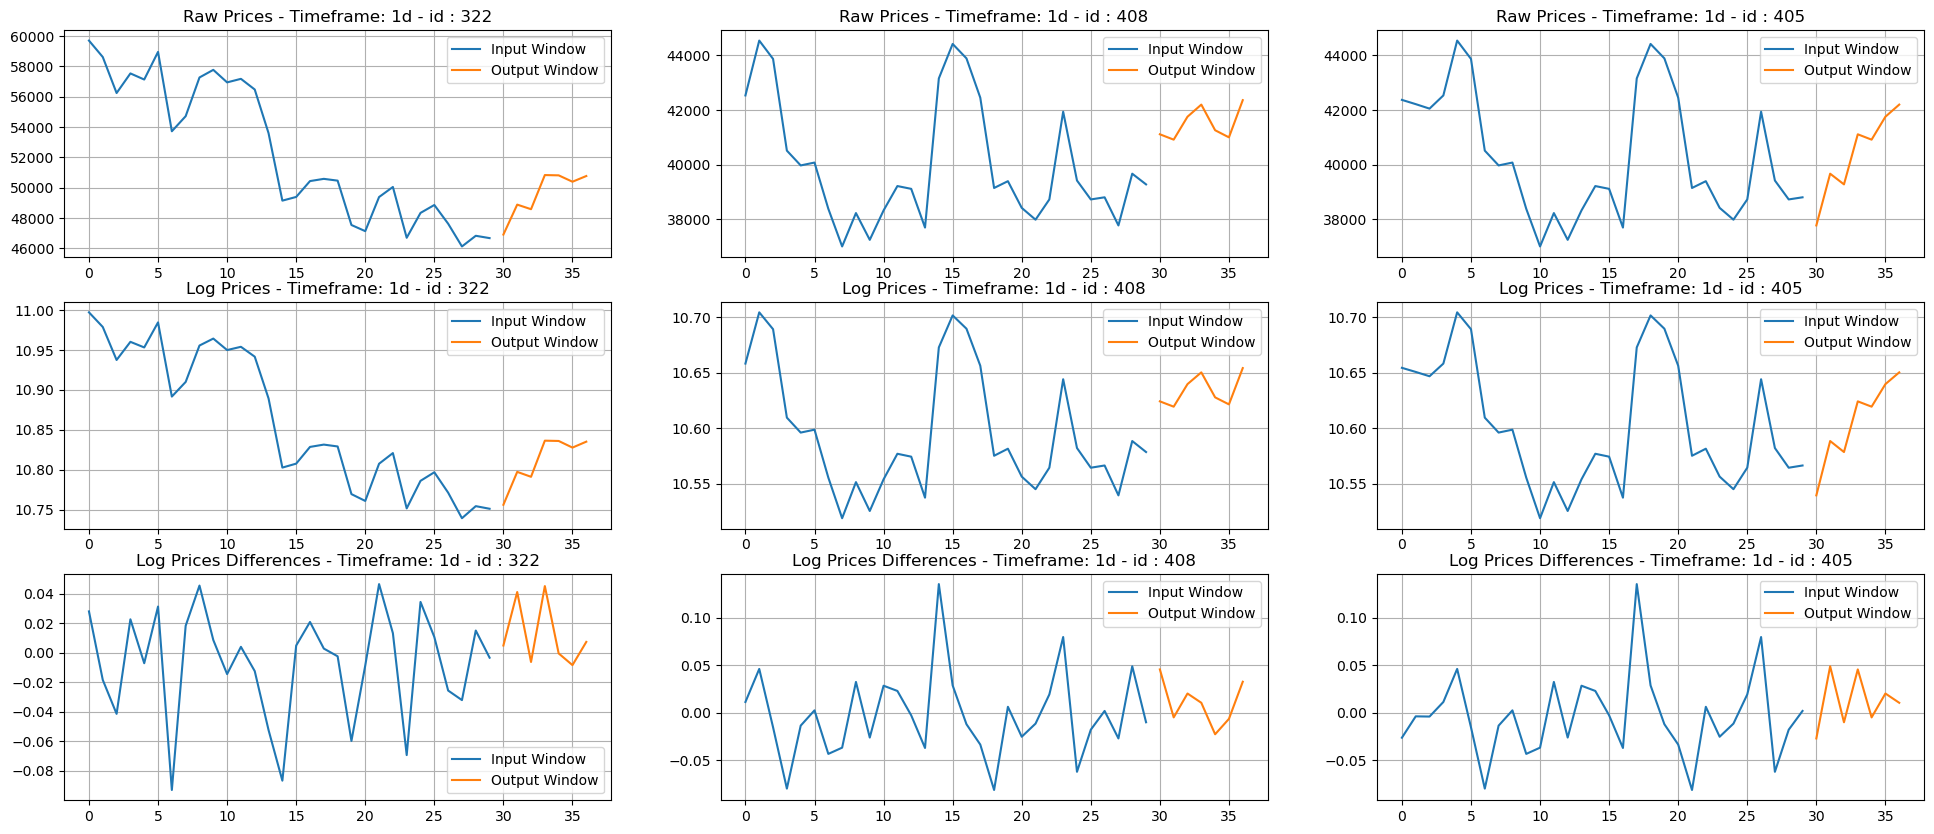

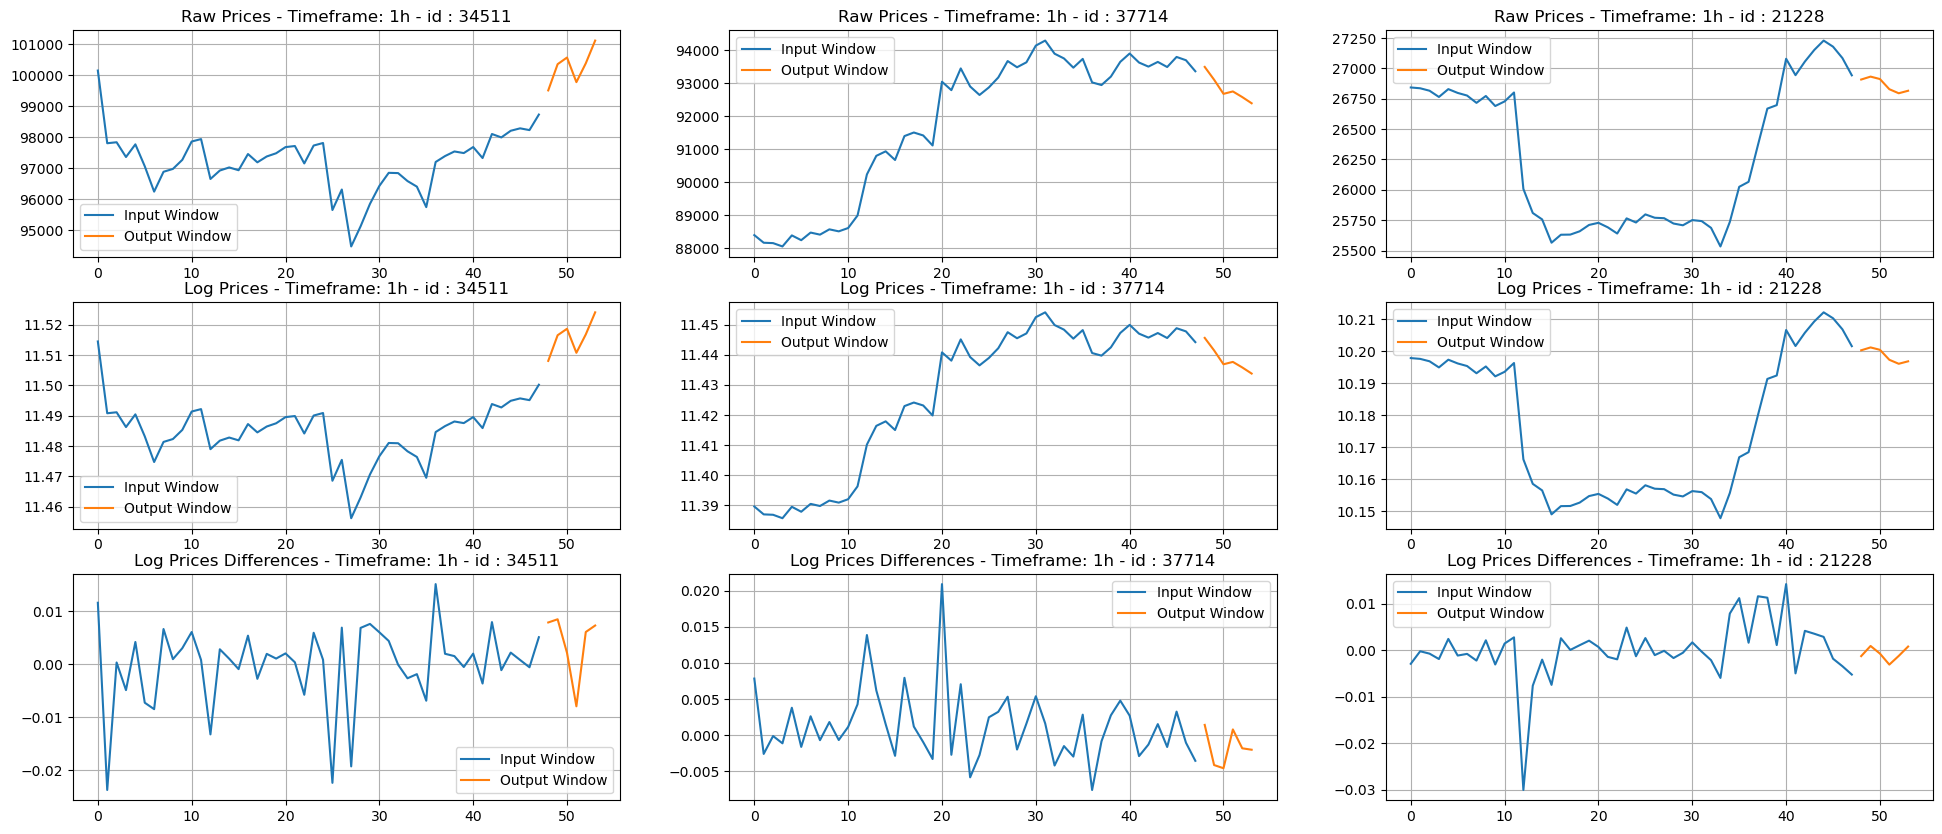

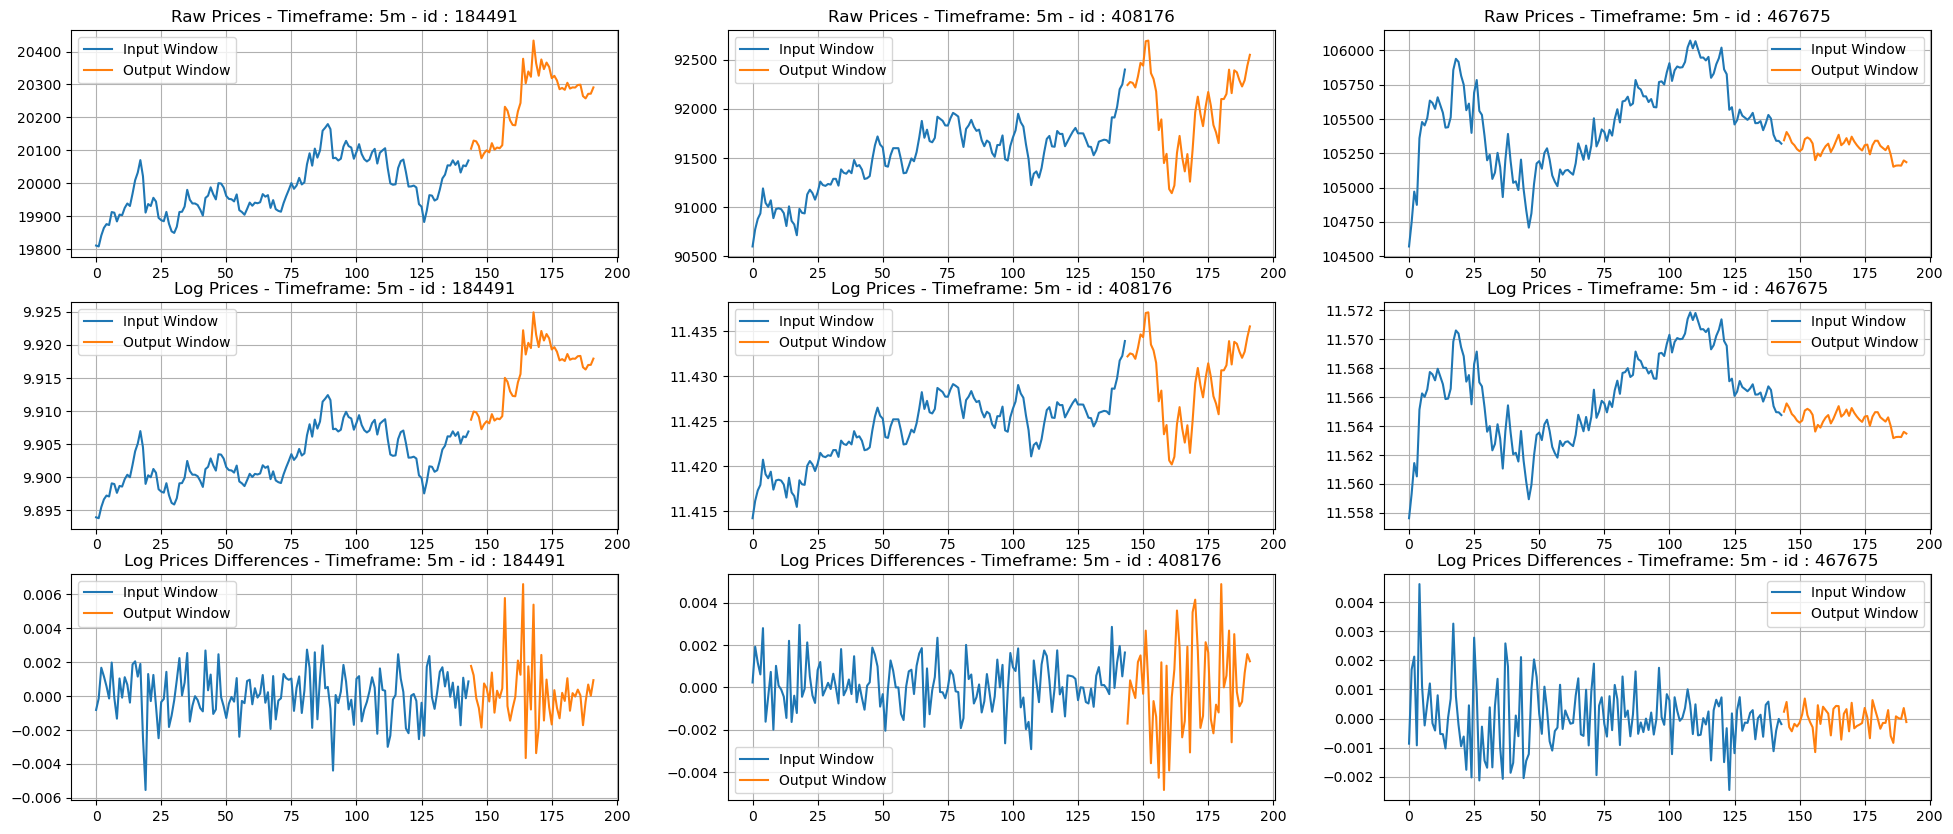

In [6]:
timeframes = ["1d", "1h", "5m"]

for timeframe in timeframes:
    fig, ax = plt.subplots(nrows=3, ncols =3, figsize=(24, 10))
    X, Y = data[timeframe]
    X_logs, Y_logs = data_logs[timeframe]
    X_log_diffs, Y_log_diffs = data_log_diffs[timeframe]

    idx = np.random.choice(len(X), size=3, replace=False)

    for i, id in enumerate(idx):
        # raw prices
        ax[0,i].plot(X[id], label='Input Window')
        ax[0,i].plot(range(len(X[id]), len(X[id]) + len(Y[id])), Y[id], label='Output Window')
        ax[0,i].set_title(f'Raw Prices - Timeframe: {timeframe} - id : {id}')
        ax[0,i].grid()
        ax[0,i].legend()
        # log prices
        ax[1,i].plot(X_logs[id], label='Input Window')
        ax[1,i].plot(range(len(X_logs[id]), len(X_logs[id]) + len(Y_logs[id])), Y_logs[id], label='Output Window')
        ax[1,i].set_title(f'Log Prices - Timeframe: {timeframe} - id : {id}')
        ax[1,i].grid()
        ax[1,i].legend()
        # log diff prices
        ax[2,i].plot(X_log_diffs[id], label='Input Window')
        ax[2,i].plot(range(len(X_log_diffs[id]), len(X_log_diffs[id]) + len(Y_log_diffs[id])), Y_log_diffs[id], label='Output Window')
        ax[2,i].set_title(f'Log Prices Differences - Timeframe: {timeframe} - id : {id}')
        ax[2,i].grid()
        ax[2,i].legend()
        
    plt.show()

# LSTM

In [7]:
# form datasets and dataloaders for PyTorch training
class TimeSerieDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).squeeze().to(device) # Ensure y is of shape (N,)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 512

# Price - Training a LSTM on a family of time series (given time frame)

In [8]:
price_datasets = {}

for timeframe in timeframes:
    X, Y = data[timeframe]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    train_dataset = TimeSerieDataset(X_train, Y_train)
    test_dataset = TimeSerieDataset(X_test, Y_test)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    price_datasets[timeframe] = (train_loader, test_loader, params[timeframe][1], params[timeframe][2])
    
    print(f"Timeframe: {timeframe}, Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}, Input window: {params[timeframe][1]}, Output window: {params[timeframe][2]}")

Timeframe: 1d, Train samples: 1402, Test samples: 351, Input window: 30, Output window: 7
Timeframe: 1h, Train samples: 34287, Test samples: 8572, Input window: 48, Output window: 6
Timeframe: 5m, Train samples: 411764, Test samples: 102941, Input window: 144, Output window: 48


In [9]:
# Early stopping class to prevent overfitting

class EarlyStoppingCallback:
    def __init__(self, patience=1, min_delta=0):
        # how many epochs do we accept with validation loss non decreasing
        self.patience = patience
        # tolerance for non decrease
        self.min_delta = min_delta
        # how many epochs without validation loss decrease
        self.counter = 0
        # minimum validation loss to beat
        self.min_validation_loss = float('inf')
        self.status = False

    def early_stop(self, validation_loss):
        # is the last validation loss better than the current minimum ?
        # status = True means stop training
        if validation_loss < self.min_validation_loss:
            # yes : update minimum value and reset counter
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.status = False
            # no : are we within tolerance ?
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # no : increase counter (losing patience)
            self.counter += 1
            # have we lost patience ?
            if self.counter >= self.patience:
                # yes
                self.status = True
            else:
                # no
                self.status = False

        return self.status, self.counter

### LSTM Model

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=7, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, inputs):
        """Forward pass through the network.
            x has shape (batch_size, seq_length, input_size)
        """
        h0 = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
        
        x, _ = self.lstm(inputs.unsqueeze(-1), (h0, c0))  # out shape: (batch_size, seq_length, hidden_size)
        x = self.dropout(x[:,-1,:])  # Apply dropout to the last time step's output
        x = self.fc(x)  # out shape: (batch_size, output_size)
        
        return x
    
    def __repr__(self):
        return f"LSTMModel(input_size={self.lstm.input_size}, hidden_size={self.hidden_size}, num_layers={self.num_layers}, output_size={self.fc.out_features}, dropout={self.dropout.p})"

### Training

In [11]:
# One Training Step
def train_step(model, train_loader, learning_rate, criterion, optimizer):
    """Perform one training step on the model."""
    
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        epoch_loss += loss.item()
        
    return model, epoch_loss/len(train_loader)

# One Test Step
def test_step(model, test_loader, criterion):
    """Perform one test step on the model."""
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs.squeeze(), y_batch)
            test_loss += loss.item()
    
    return test_loss / len(test_loader)

In [12]:
def train_model(model, train_loader, test_loader, n_epochs, learning_rate, criterion, optimizer, display_frequency=10, early_stopping=None):
    """Train the model with early stopping."""
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        # Train step
        model, train_loss = train_step(model, train_loader, learning_rate, criterion, optimizer)
        training_losses.append(train_loss)

        # Test step
        validation_loss = test_step(model, test_loader, criterion)
        validation_losses.append(validation_loss)
        
        # Save the best model
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            # torch.save(model.state_dict(), PATH_TO_SAVE)
            msg = f'Saving model at epoch {epoch+1} with validation loss {validation_loss:.4e}'
        else:
            msg = ''
        
        if epoch % display_frequency == 0 or epoch == n_epochs - 1:
            print(f'Epoch [{epoch+1:<6} .../... {n_epochs:<6}], Training Loss: {train_loss:.4e}, Validation Loss: {validation_loss:.4e} - {msg}')

        # Early stopping check
        if early_stopping:
            stop, counter = early_stopping.early_stop(validation_loss)
            if stop:
                print(f'Early stopping at epoch {epoch+1} with counter {counter}')
                break

    return model, training_losses, validation_losses

In [13]:
patience = 100
min_delta = 1e+2
hidden_size = 256
num_layers = 16
dropout = 0.2
n_epochs = 10000

In [21]:
timeframe = "1h"  # Choose timeframe
dropout = 0.2
train_loader, test_loader, input_window, output_window = price_datasets[timeframe]
lstm = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=output_window, dropout=dropout).to(device)

print(lstm)

learning_rate = 1e-1
criterion = nn.MSELoss()  # Mean Squared Error loss for regression

optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

early_stopping = EarlyStoppingCallback(patience=patience, min_delta=min_delta)

LSTMModel(input_size=1, hidden_size=256, num_layers=16, output_size=6, dropout=0.2)


In [15]:
train_loader, test_loader, _, _ = price_datasets[timeframe]

trained_model, training_losses, validation_losses = train_model(
    model=lstm, 
    train_loader=train_loader,
    test_loader=test_loader, 
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,
    optimizer=optimizer,
    early_stopping=early_stopping,
    display_frequency=1
    # early_stopping=None
)

Epoch [1      .../... 10000 ], Training Loss: 3.6999e+09, Validation Loss: 3.6762e+09 - Saving model at epoch 1 with validation loss 3.6762e+09
Epoch [2      .../... 10000 ], Training Loss: 3.6178e+09, Validation Loss: 3.5949e+09 - Saving model at epoch 2 with validation loss 3.5949e+09
Epoch [3      .../... 10000 ], Training Loss: 3.5376e+09, Validation Loss: 3.5152e+09 - Saving model at epoch 3 with validation loss 3.5152e+09
Epoch [4      .../... 10000 ], Training Loss: 3.4589e+09, Validation Loss: 3.4373e+09 - Saving model at epoch 4 with validation loss 3.4373e+09
Epoch [5      .../... 10000 ], Training Loss: 3.3825e+09, Validation Loss: 3.3612e+09 - Saving model at epoch 5 with validation loss 3.3612e+09
Epoch [6      .../... 10000 ], Training Loss: 3.3077e+09, Validation Loss: 3.2868e+09 - Saving model at epoch 6 with validation loss 3.2868e+09
Epoch [7      .../... 10000 ], Training Loss: 3.2344e+09, Validation Loss: 3.2140e+09 - Saving model at epoch 7 with validation loss 3.2

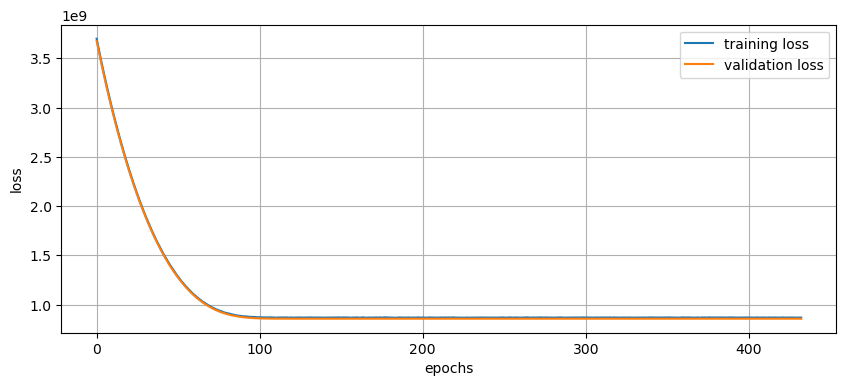

In [16]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(training_losses, label='training loss')
ax.plot(validation_losses, label='validation loss')
# ax.set_yscale('log')
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
ax.legend()
ax.grid(True)
plt.show()

### Sample some forecasts

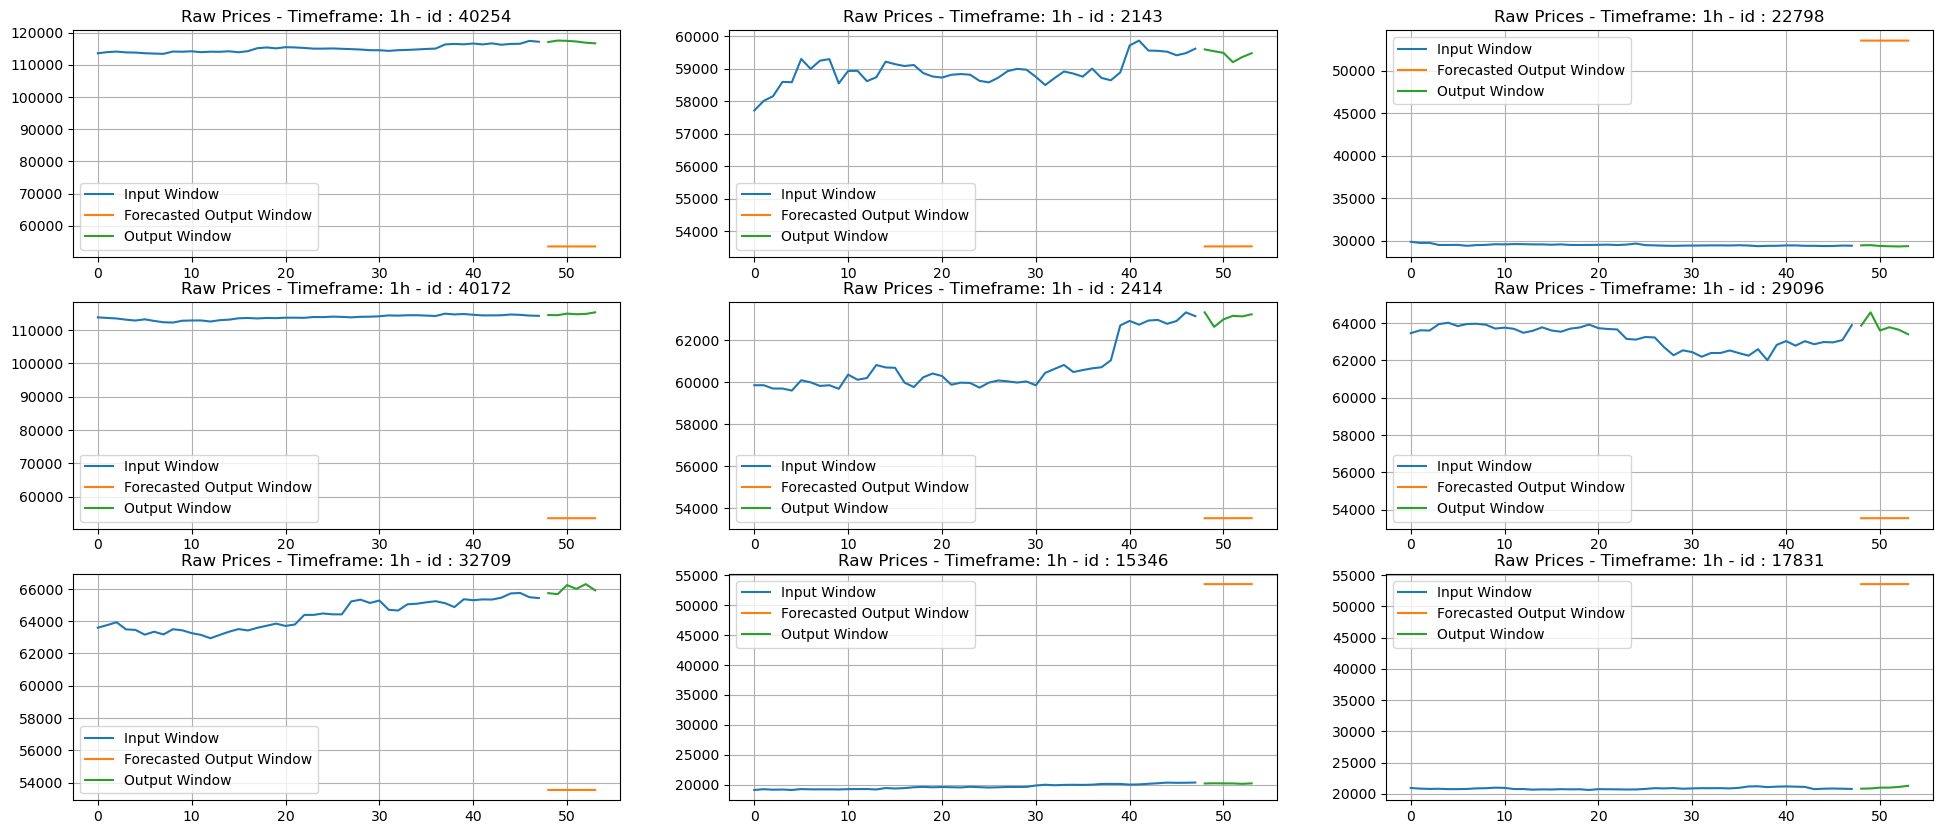

In [17]:
timeframes = [timeframe]

for timeframe in timeframes:
    fig, ax = plt.subplots(nrows=3, ncols =3, figsize=(24, 10))
    X, Y = data[timeframe]
    # X_logs, Y_logs = data_logs[timeframe]
    # X_log_diffs, Y_log_diffs = data_log_diffs[timeframe]

    idx = np.random.choice(len(X), size=3*3, replace=False)

    for i, id in enumerate(idx):
        # raw prices
        ax[i//3,i%3].plot(X[id], label='Input Window')
        # forecast with trained model
        lstm.eval()
        with torch.no_grad():
            input_seq = torch.tensor(X[id], dtype=torch.float32).unsqueeze(0).to(device)  # shape (1, seq_length)
            forecast = lstm(input_seq).cpu().numpy().squeeze()  # shape (output_size,)
        ax[i//3,i%3].plot(range(len(X[id]), len(X[id]) + len(forecast)), forecast, label='Forecasted Output Window')
        ax[i//3,i%3].plot(range(len(X[id]), len(X[id]) + len(Y[id])), Y[id], label='Output Window')
        ax[i//3,i%3].set_title(f'Raw Prices - Timeframe: {timeframe} - id : {id}')
        ax[i//3,i%3].grid()
        ax[i//3,i%3].legend()
        
    plt.show()

# Training a LSTM on the family of log returns

In [18]:
log_returns_datasets = {}

for timeframe in timeframes:
    X, Y = data_log_diffs[timeframe]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    train_dataset = TimeSerieDataset(X_train, Y_train)
    test_dataset = TimeSerieDataset(X_test, Y_test)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    log_returns_datasets[timeframe] = (train_loader, test_loader, params[timeframe][1], params[timeframe][2])
    
    print(f"Timeframe: {timeframe}, Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}, Input window: {params[timeframe][1]}, Output window: {params[timeframe][2]}")

Timeframe: 1h, Train samples: 34287, Test samples: 8572, Input window: 48, Output window: 6


In [24]:
# timeframe = "1h"  # Choose timeframe

train_loader, test_loader, input_window, output_window = price_datasets[timeframe]
lstm = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=output_window, dropout=dropout).to(device)

print(lstm)

learning_rate = 1e-1
criterion = nn.MSELoss()  # Mean Squared Error loss for regression

optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

early_stopping = EarlyStoppingCallback(patience=patience, min_delta=min_delta)

LSTMModel(input_size=1, hidden_size=256, num_layers=16, output_size=6, dropout=0.2)


In [25]:
# n_epochs = 1000
train_loader, test_loader, _, _ = price_datasets[timeframe]

trained_model, training_losses, validation_losses = train_model(
    model=lstm, 
    train_loader=train_loader,
    test_loader=test_loader, 
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,
    optimizer=optimizer,
    early_stopping=early_stopping,
    # early_stopping=None
    display_frequency=1
)

Epoch [1      .../... 10000 ], Training Loss: 3.6984e+09, Validation Loss: 3.6731e+09 - Saving model at epoch 1 with validation loss 3.6731e+09
Epoch [2      .../... 10000 ], Training Loss: 3.6128e+09, Validation Loss: 3.5881e+09 - Saving model at epoch 2 with validation loss 3.5881e+09
Epoch [3      .../... 10000 ], Training Loss: 3.5294e+09, Validation Loss: 3.5052e+09 - Saving model at epoch 3 with validation loss 3.5052e+09
Epoch [4      .../... 10000 ], Training Loss: 3.4475e+09, Validation Loss: 3.4242e+09 - Saving model at epoch 4 with validation loss 3.4242e+09
Epoch [5      .../... 10000 ], Training Loss: 3.3677e+09, Validation Loss: 3.3451e+09 - Saving model at epoch 5 with validation loss 3.3451e+09
Epoch [6      .../... 10000 ], Training Loss: 3.2902e+09, Validation Loss: 3.2680e+09 - Saving model at epoch 6 with validation loss 3.2680e+09
Epoch [7      .../... 10000 ], Training Loss: 3.2145e+09, Validation Loss: 3.1925e+09 - Saving model at epoch 7 with validation loss 3.1

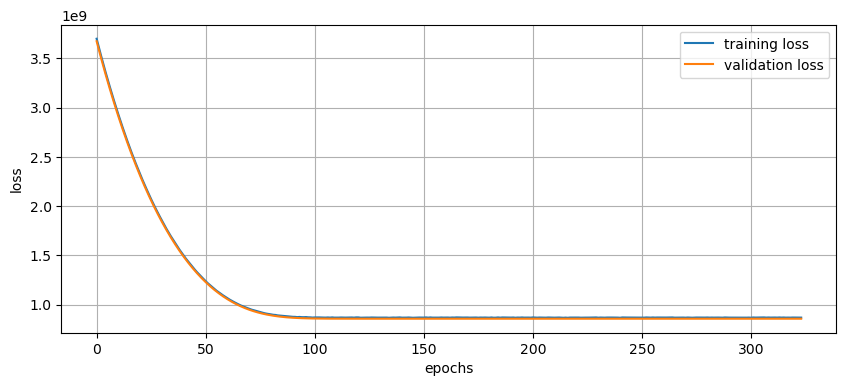

In [26]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(training_losses, label='training loss')
ax.plot(validation_losses, label='validation loss')
# ax.set_yscale('log')
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
ax.legend()
ax.grid(True)
plt.show()

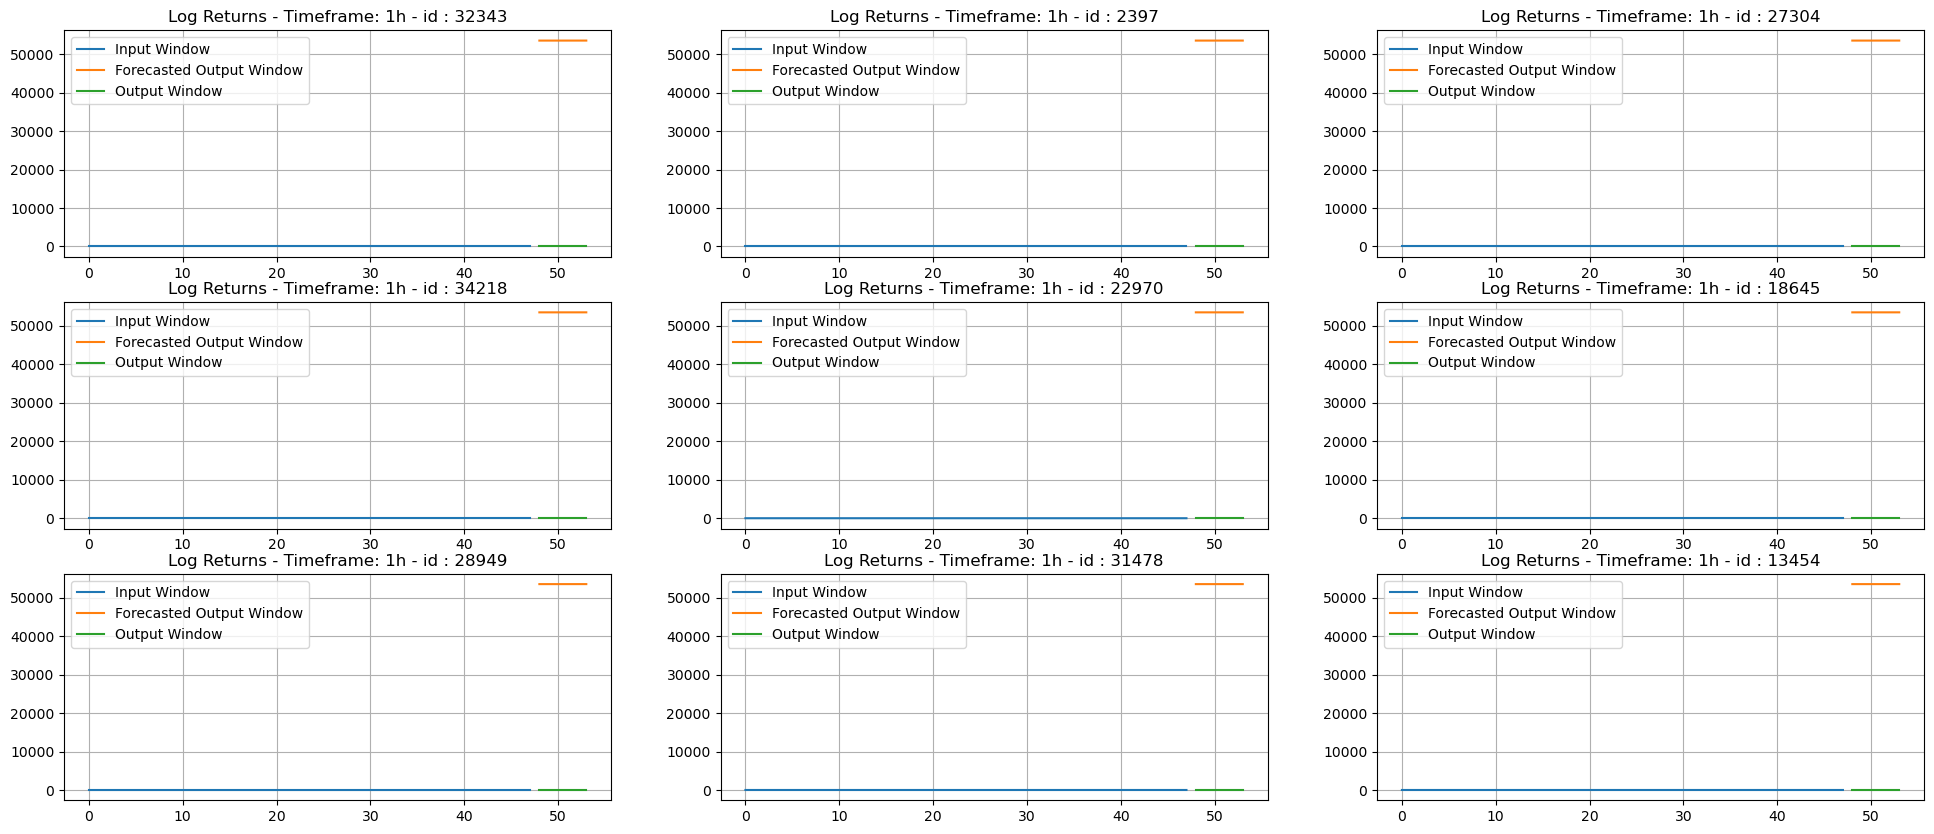

In [27]:
timeframes = [timeframe]

for timeframe in timeframes:
    fig, ax = plt.subplots(nrows=3, ncols =3, figsize=(24, 10))
    # X, Y = data[timeframe]
    # X_logs, Y_logs = data_logs[timeframe]
    X_log_diffs, Y_log_diffs = data_log_diffs[timeframe]

    idx = np.random.choice(len(X), size=3*3, replace=False)

    for i, id in enumerate(idx):
        # raw prices
        ax[i//3,i%3].plot(X_log_diffs[id], label='Input Window')
        # forecast with trained model
        lstm.eval()
        with torch.no_grad():
            input_seq = torch.tensor(X_log_diffs[id], dtype=torch.float32).unsqueeze(0).to(device)  # shape (1, seq_length, 1)
            forecast = lstm(input_seq).cpu().numpy().squeeze()  # shape (output_size,)
        ax[i//3,i%3].plot(range(len(X_log_diffs[id]), len(X_log_diffs[id]) + len(forecast)), forecast, label='Forecasted Output Window')
        ax[i//3,i%3].plot(range(len(X_log_diffs[id]), len(X_log_diffs[id]) + len(Y_log_diffs[id])), Y_log_diffs[id], label='Output Window')
        ax[i//3,i%3].set_title(f'Log Returns - Timeframe: {timeframe} - id : {id}')
        ax[i//3,i%3].grid()
        ax[i//3,i%3].legend()
        
    plt.show()

# Training a LSTM on ONE time serie

In [28]:
# timeframe = "5m"  # Choose timeframe
# X, Y = data_log_diffs[timeframe]

# id = np.random.choice(len(X), size=1)[0]

# x = X[id]
# y_true = Y[id]

In [29]:
# fig, ax = plt.subplots(figsize=(12,6))
# ax.plot(x, label='Input Window')
# ax.plot(range(len(x), len(x) + len(y_true)), y_true, label='True Output Window')
# ax.set_title    (f'Raw Prices - Timeframe: {timeframe} - id : {id}')
# ax.grid()
# ax.legend()
# plt.show()

In [30]:
# # Create mini dataset for single time serie
# input_window = int(len(x)/2)
# output_window = params[timeframe][2]
# print(f"Input window: {input_window}, Output window: {output_window}")

In [31]:
# n = len(x)
# X_ts = np.zeros((n - input_window - output_window + 1, input_window))
# Y_ts = np.zeros((n - input_window - output_window + 1, output_window))

# for i in range(n-input_window-output_window):
#     X_ts[i] = x[i:i+input_window]
#     Y_ts[i, :] = x[i+input_window:i+input_window+output_window]

In [32]:
# print(X_ts.shape, Y_ts.shape)

# train_dataset = TimeSerieDataset(X_ts, Y_ts)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = train_loader  # Using train data as test data for demo purposes

In [33]:
# lstm = LSTMModel(input_size=1, hidden_size=128, num_layers=4, output_size=output_window, dropout=dropout).to(device)

# print(lstm)

# learning_rate = 1e-1
# criterion = nn.MSELoss()  # Mean Squared Error loss for regression

# optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# early_stopping = EarlyStoppingCallback(patience=30, min_delta=1e-4)

In [34]:
# n_epochs = 100

# trained_model, training_losses, validation_losses = train_model(
#     model=lstm, 
#     train_loader=train_loader,
#     test_loader=test_loader, 
#     n_epochs=n_epochs,
#     learning_rate=learning_rate,
#     criterion=criterion,
#     optimizer=optimizer,
#     early_stopping=early_stopping
#     # early_stopping=None
# )

In [35]:
# fig, ax = plt.subplots(figsize=(10,4))

# ax.plot(training_losses, label='training loss')
# ax.plot(validation_losses, label='validation loss')
# # ax.set_yscale('log')
# ax.set_ylabel('loss')
# ax.set_xlabel('epochs')
# ax.legend()
# ax.grid(True)
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(12,6))
# ax.plot(x, label='Input Window')
# ax.plot(range(len(x), len(x) + len(y_true)), y_true, label='True Output Window')
# # forecast with trained model
# lstm.eval()
# with torch.no_grad():
#     input_seq = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)  # shape (1, seq_length)
#     forecast = lstm(input_seq).cpu().numpy().squeeze()  # shape (output_size,)
# ax.plot(range(len(x), len(x) + len(forecast)), forecast, label='Forecasted Output Window')
# ax.set_title    (f'Raw Prices - Timeframe: {timeframe} - id : {id}')
# ax.legend()
# ax.grid()

plt.show() 